# Part 1: Language Modeling / Regression:

### 1. Establishing a preprocessing NLP pipeline (Tokenization stemming lemmatization, Stop words, Discretization, etc) on the collected Dataset:

In [54]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from gensim.models import Word2Vec
import numpy as np

In [13]:
df = pd.read_csv('answers.csv')
df.head()

,id,answer,score,correct
0,1.1,High risk problems are address in the prototyp...,3.5,0.0
1,1.1,To simulate portions of the desired final prod...,5.0,1.0
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0
4,1.1,It is used to let the users have a first idea ...,3.0,0.0


In [14]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# Tokenization
df['tokens'] = df['answer'].apply(word_tokenize)
df['answer'].head(3), df['tokens'].head(3)

(0    High risk problems are address in the prototyp...
 1    To simulate portions of the desired final prod...
 2    A prototype program simulates the behaviors of...
 Name: answer, dtype: object,
 0    [High, risk, problems, are, address, in, the, ...
 1    [To, simulate, portions, of, the, desired, fin...
 2    [A, prototype, program, simulates, the, behavi...
 Name: tokens, dtype: object)

In [26]:
# Stop words removal
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [28]:
df['tokens'].head()

0    [High, risk, problems, address, prototype, pro...
1    [simulate, portions, desired, final, product, ...
2    [prototype, program, simulates, behaviors, por...
3    [Defined, Specification, phase, prototype, sti...
4    [used, let, users, first, idea, completed, pro...
Name: tokens, dtype: object

In [29]:
# Stemming
stemmer = PorterStemmer()
df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Discretization of the 'score' column
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['score_binned'] = discretizer.fit_transform(df[['score']])

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [30]:
df.head()

,id,answer,score,correct,tokens,stemmed,lemmatized,score_binned
0,1.1,High risk problems are address in the prototyp...,3.5,0.0,"[High, risk, problems, address, prototype, pro...","[high, risk, problem, address, prototyp, progr...","[High, risk, problem, address, prototype, prog...",2.0
1,1.1,To simulate portions of the desired final prod...,5.0,1.0,"[simulate, portions, desired, final, product, ...","[simul, portion, desir, final, product, quick,...","[simulate, portion, desired, final, product, q...",2.0
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0,"[prototype, program, simulates, behaviors, por...","[prototyp, program, simul, behavior, portion, ...","[prototype, program, simulates, behavior, port...",2.0
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0,"[Defined, Specification, phase, prototype, sti...","[defin, specif, phase, prototyp, stimul, behav...","[Defined, Specification, phase, prototype, sti...",2.0
4,1.1,It is used to let the users have a first idea ...,3.0,0.0,"[used, let, users, first, idea, completed, pro...","[use, let, user, first, idea, complet, program...","[used, let, user, first, idea, completed, prog...",1.0


## 2. Encode your Data vectors By using Word2vec (CBOW, Skip Gram), Bag Of words, TF-IDF:

In [40]:
# Prepare the text data for vectorization
df['processed'] = df['lemmatized'].apply(lambda x: ' '.join(x))

# Word2Vec (CBOW and Skip Gram)
# CBOW
word2vec_cbow = Word2Vec(sentences=df['lemmatized'], vector_size=100, window=5, min_count=1, sg=0)
# Skip Gram
word2vec_sg = Word2Vec(sentences=df['lemmatized'], vector_size=100, window=5, min_count=1, sg=1)

In [44]:
# Function to average word vectors for a document
def get_avg_word2vec(tokens_list, model, vector_size):
    vectors = [model.wv[word] for word in tokens_list if word in model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(vector_size)

# Apply Word2Vec to the data
df['word2vec_cbow'] = df['lemmatized'].apply(lambda x: get_avg_word2vec(x, word2vec_cbow, 100))
df['word2vec_sg'] = df['lemmatized'].apply(lambda x: get_avg_word2vec(x, word2vec_sg, 100))

# Function to plot 2D vectors
def plot_2d_vectors(vectors, title):
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
    for i, word in enumerate(df['answer']):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Convert word2vec columns to numpy arrays
cbow_vectors = np.array(df['word2vec_cbow'].tolist())
sg_vectors = np.array(df['word2vec_sg'].tolist())

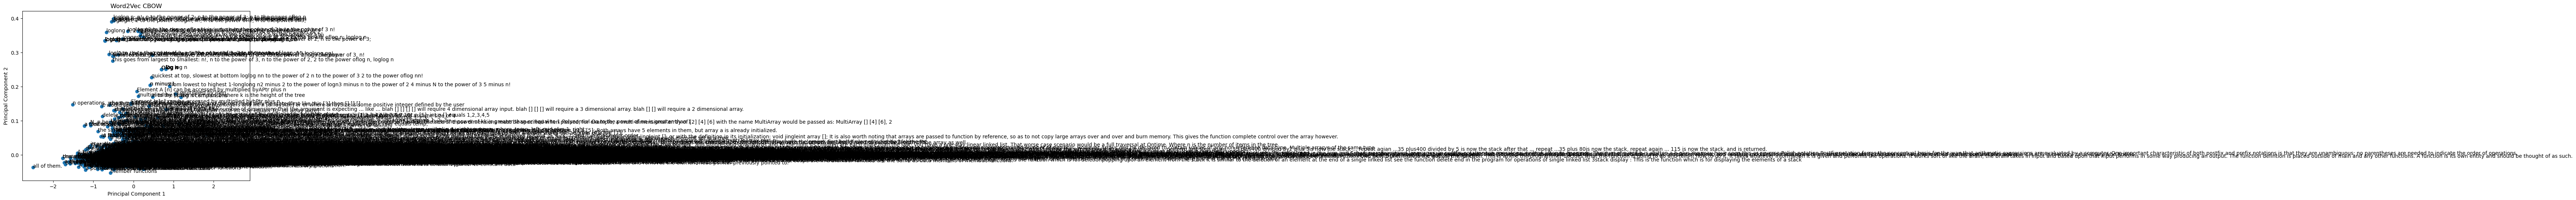

In [34]:
# Plot CBOW vectors
plot_2d_vectors(cbow_vectors, 'Word2Vec CBOW')

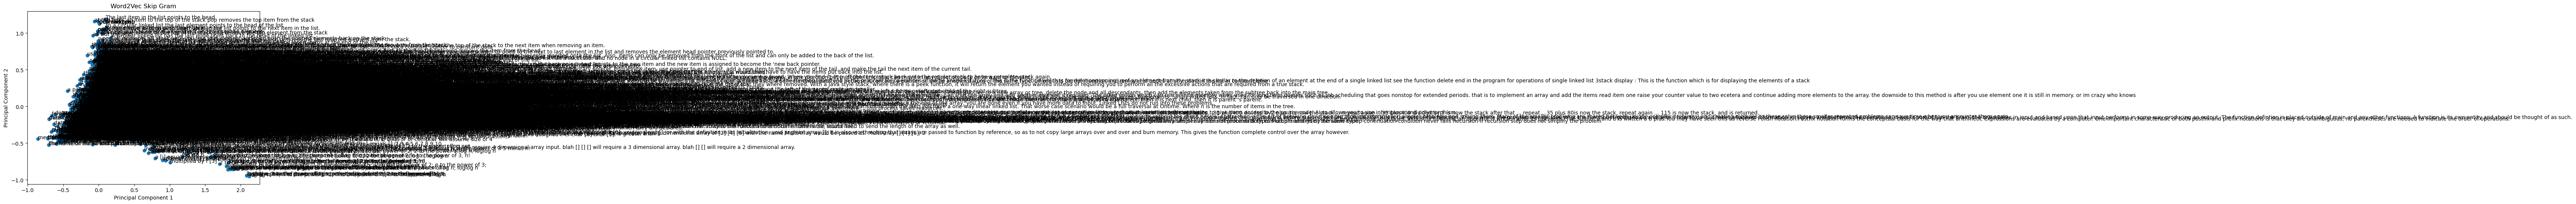

In [35]:
# Plot Skip Gram vectors
plot_2d_vectors(sg_vectors, 'Word2Vec Skip Gram')

## 3. Training the models by using SVR, Naive Bayes, Linear Regression , Decision Tree Algorithms (with Word2Vec embedding):

In [46]:
# Prepare features and target variable
X_cbow = np.array(df['word2vec_cbow'].tolist())
X_sg = np.array(df['word2vec_sg'].tolist())
y = df['score']

In [47]:
# Split the dataset
X_train_cbow, X_test_cbow, y_train, y_test = train_test_split(X_cbow, y, test_size=0.2, random_state=42)
X_train_sg, X_test_sg, y_train, y_test = train_test_split(X_sg, y, test_size=0.2, random_state=42)

In [48]:
# Initialize models
svr = SVR()
nb = GaussianNB()
lr = LinearRegression()
dt = DecisionTreeRegressor()

In [51]:
# Training the models using CBOW embeddings
svr.fit(X_train_cbow, y_train)
lr.fit(X_train_cbow, y_train)
dt.fit(X_train_cbow, y_train)

y_pred_svr_cbow = svr.predict(X_test_cbow)
y_pred_lr_cbow = lr.predict(X_test_cbow)
y_pred_dt_cbow = dt.predict(X_test_cbow)

In [52]:
# Training the models using Skip Gram embeddings
svr.fit(X_train_sg, y_train)
lr.fit(X_train_sg, y_train)
dt.fit(X_train_sg, y_train)

y_pred_svr_sg = svr.predict(X_test_sg)
y_pred_lr_sg = lr.predict(X_test_sg)
y_pred_dt_sg = dt.predict(X_test_sg)

## 4. Evaluating the four languages models by using standards metrics (MSE , RMSE, etc), choose the best model then argument your choice :

In [58]:
mse_svr_cbow = mean_squared_error(y_test, y_pred_svr_cbow)
mse_lr_cbow = mean_squared_error(y_test, y_pred_lr_cbow)
mse_dt_cbow = mean_squared_error(y_test, y_pred_dt_cbow)

rmse_svr_cbow = np.sqrt(mse_svr_cbow)
rmse_lr_cbow = np.sqrt(mse_lr_cbow)
rmse_dt_cbow = np.sqrt(mse_dt_cbow)

mse_svr_sg = mean_squared_error(y_test, y_pred_svr_sg)
mse_lr_sg = mean_squared_error(y_test, y_pred_lr_sg)
mse_dt_sg = mean_squared_error(y_test, y_pred_dt_sg)

rmse_svr_sg = np.sqrt(mse_svr_sg)
rmse_lr_sg = np.sqrt(mse_lr_sg)
rmse_dt_sg = np.sqrt(mse_dt_sg)

In [56]:
print("CBOW Embeddings:")
print("SVR Mean Squared Error:", mse_svr_cbow)
print("SVR Root Mean Squared Error:", rmse_svr_cbow)
print("Linear Regression Mean Squared Error:", mse_lr_cbow)
print("Linear Regression Root Mean Squared Error:", rmse_lr_cbow)
print("Decision Tree Mean Squared Error:", mse_dt_cbow)
print("Decision Tree Root Mean Squared Error:", rmse_dt_cbow)

CBOW Embeddings:
SVR Mean Squared Error: 1.789242074727876
SVR Root Mean Squared Error: 1.337625536063018
Linear Regression Mean Squared Error: 1.1964488772270392
Linear Regression Root Mean Squared Error: 1.0938230557210975
Decision Tree Mean Squared Error: 2.2477135878209498
Decision Tree Root Mean Squared Error: 1.4992376688907432


In [59]:
print("\nSkip Gram Embeddings:")
print("SVR Mean Squared Error:", mse_svr_sg)
print("SVR Root Mean Squared Error:", rmse_svr_sg)
print("Linear Regression Mean Squared Error:", mse_lr_sg)
print("Linear Regression Root Mean Squared Error:", rmse_lr_sg)
print("Decision Tree Mean Squared Error:", mse_dt_sg)
print("Decision Tree Root Mean Squared Error:", rmse_dt_sg)


Skip Gram Embeddings:
SVR Mean Squared Error: 1.5271543089873627
SVR Root Mean Squared Error: 1.2357808499031544
Linear Regression Mean Squared Error: 1.2162605763676502
Linear Regression Root Mean Squared Error: 1.1028420450670395
Decision Tree Mean Squared Error: 1.818521358782095
Decision Tree Root Mean Squared Error: 1.3485256240732302


<ul>
    <li><b>Linear Regression </b> performs better than <b>SVR</b> and Decision Tree for both CBOW and Skip Gram embeddings, having the lowest MSE and RMSE in both cases.</li>
    <li><b>Linear Regression </b>performs better than <b>SVR</b> and Decision Tree for both CBOW and Skip Gram embeddings, having the lowest MSE and RMSE in both cases.</li>
    <li>Comparing <b>CBOW</b> and <b>Skip Gram</b> embeddings for Linear Regression, CBOW has slightly better performance with an MSE of 1.1964 and RMSE of 1.0938 compared to Skip Gram's MSE of 1.2163 and RMSE of 1.1028.</li>

Argument for Choice:

<ul>
    <li><b>Performance:</b> Linear Regression with CBOW embeddings achieved the lowest MSE and RMSE, indicating better accuracy and lower prediction error compared to other models.</li>
    <li><b>Simplicity:</b> Linear Regression is a simpler and more interpretable model compared to SVR and Decision Trees, making it easier to understand and explain the relationship between features and the target variable.</li>
    <li><b>Consistency:</b> Both Linear Regression models (with CBOW and Skip Gram) showed consistent performance, but CBOW embeddings slightly outperformed Skip Gram, making it the best overall choice.</li>

## 5.  Interpreting the Obtained Results :

<h3>Best Model Selection</h3>
The best performing model is Linear Regression with CBOW embeddings.
This model has the lowest MSE (1.1964) and RMSE (1.0938), indicating that it makes the most accurate predictions among the models tested.
<h3>Significance of Results</h3>
<ul>
    <li><b>Model Performance:</b> Linear Regression with CBOW embeddings shows the best performance, suggesting that a linear relationship between the CBOW-embedded features and the target variable (score) is well-captured by this model. The low RMSE indicates that, on average, the model's predictions are within approximately 1.09 units of the actual scores.</li>
    <li><b>Model Choice:</b> The simplicity and interpretability of Linear Regression make it a strong choice, especially when it also delivers the best performance metrics. This is valuable for understanding the impact of different features on the target variable.</li>
    <li><b>Embedding Method:</b> CBOW embeddings slightly outperform Skip Gram embeddings in this context, indicating that summarizing the context into a single vector (CBOW) is more effective than predicting context words from the target word (Skip Gram) for this dataset.</li>

# Part 2: Language Modeling / Classification:

### 1. Establishing a preprocessing NLP pipeline (Tokenization stemming lemmatization, Stop words, Discretization, etc) on the collected Dataset:

In [73]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [65]:
# importing the Twitter dataset
df = pd.read_csv('twitter_training.csv')
# Assigning new column names
df.columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']
df.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [69]:
df = df.dropna(subset=['Tweet content'])

In [70]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Tokenization
df['tokens'] = df['Tweet content'].apply(word_tokenize)

# Stop words removal
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Stemming
stemmer = PorterStemmer()
df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Discretization is not typically used in text data preprocessing, so we will skip it

# Encode the sentiment labels
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiment'])

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Tweet ID,entity,sentiment,Tweet content,tokens,stemmed,lemmatized,encoded_sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[coming, borders, kill, ,]","[come, border, kill, ,]","[coming, border, kill, ,]",3
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, getting, borderlands, kill, ,]","[im, get, borderland, kill, ,]","[im, getting, borderland, kill, ,]",3
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, coming, borderlands, murder, ,]","[im, come, borderland, murder, ,]","[im, coming, borderland, murder, ,]",3
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, getting, borderlands, 2, murder, ,]","[im, get, borderland, 2, murder, ,]","[im, getting, borderland, 2, murder, ,]",3
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,"[im, getting, borderlands, murder, ,]","[im, get, borderland, murder, ,]","[im, getting, borderland, murder, ,]",3


### 2.  Encoding the Data vectors By using Word2vec (CBOW, Skip Gram), Bag Of words, TF-IDF :

In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Prepare the text data for vectorization
df['processed'] = df['lemmatized'].apply(lambda x: ' '.join(x))

# Bag of Words
vectorizer_bow = CountVectorizer()
bow_vectors = vectorizer_bow.fit_transform(df['processed'])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
tfidf_vectors = vectorizer_tfidf.fit_transform(df['processed'])

# Word2Vec (CBOW and Skip Gram)
# CBOW
word2vec_cbow = Word2Vec(sentences=df['lemmatized'], vector_size=100, window=5, min_count=1, sg=0)
# Skip Gram
word2vec_sg = Word2Vec(sentences=df['lemmatized'], vector_size=100, window=5, min_count=1, sg=1)

# Function to average word vectors for a document
def get_avg_word2vec(tokens_list, model, vector_size):
    vectors = [model.wv[word] for word in tokens_list if word in model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(vector_size)

# Apply Word2Vec to the data
df['word2vec_cbow'] = df['lemmatized'].apply(lambda x: get_avg_word2vec(x, word2vec_cbow, 100))
df['word2vec_sg'] = df['lemmatized'].apply(lambda x: get_avg_word2vec(x, word2vec_sg, 100))

# Prepare features and target variable
X_cbow = np.array(df['word2vec_cbow'].tolist())
X_sg = np.array(df['word2vec_sg'].tolist())
y = df['encoded_sentiment']

print("Bag of Words Vectors:\n", bow_vectors.toarray())
print("\nTF-IDF Vectors:\n", tfidf_vectors.toarray())
print("\nWord2Vec CBOW Vectors:\n", X_cbow)
print("\nWord2Vec Skip Gram Vectors:\n", X_sg)

Bag of Words Vectors:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

TF-IDF Vectors:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Word2Vec CBOW Vectors:
 [[-0.19014448  0.70755231  0.41903943 ...  0.15119943  0.58519793
   0.61007035]
 [ 0.29649994  0.53877532  0.64097613 ...  0.68857425  0.66016239
   0.55007064]
 [ 0.19781868  0.63473654  0.51521337 ...  0.49494109  0.56982958
   0.60254157]
 ...
 [-0.09333214  0.34809521  0.43683824 ...  0.33498755  0.15602826
   0.32339481]
 [ 0.05203181  0.5228048   0.37433347 ...  0.46598405  0.17252675
   0.41188496]
 [ 0.0484346   0.79654461  0.42922506 ...  0.61655504  0.27649978
   0.62058932]]

Word2Vec Skip Gram Vectors:
 [[ 0.31132287 -0.11163155 -0.16884305 ...  0.01363517  0.22896522
   0.26675513]
 [ 0.31117365 -0.15290205  0.00762838 ...  0.15612373  

### 3. Training your models by using SVM, Naive Bayes, Logistic Regression, Ada Boosting Algorithms (The embedding will be done by Word2Vec) :

In [75]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Split the dataset
X_train_cbow, X_test_cbow, y_train, y_test = train_test_split(X_cbow, y, test_size=0.2, random_state=42)
X_train_sg, X_test_sg, y_train, y_test = train_test_split(X_sg, y, test_size=0.2, random_state=42)

# Initialize models
svm = SVC()
lr = LogisticRegression()
ada = AdaBoostClassifier()

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    return accuracy, f1, precision, recall

### 4. Evaluate the four languages models by using standards metrics (Accuracy, Loss, F1 Score, etc) and other metrics like blue score :

In [74]:
# Train and evaluate models using CBOW embeddings
print("CBOW Embeddings:")
results_cbow = {}
for model_name, model in zip(['SVM', 'Logistic Regression', 'AdaBoost'], [svm, lr, ada]):
    accuracy, f1, precision, recall = train_and_evaluate(model, X_train_cbow, X_test_cbow, y_train, y_test)
    results_cbow[model_name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
    print(f"{model_name}: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

# Train and evaluate models using Skip Gram embeddings
print("\nSkip Gram Embeddings:")
results_sg = {}
for model_name, model in zip(['SVM', 'Logistic Regression', 'AdaBoost'], [svm, lr, ada]):
    accuracy, f1, precision, recall = train_and_evaluate(model, X_train_sg, X_test_sg, y_train, y_test)
    results_sg[model_name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
    print(f"{model_name}: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

CBOW Embeddings:
SVM: Accuracy=0.5372660314886141, F1 Score=0.5106325925671025, Precision=0.5392361146682931, Recall=0.5372660314886141


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy=0.5041556861950132, F1 Score=0.4833470552362318, Precision=0.4898080975768373, Recall=0.5041556861950132
AdaBoost: Accuracy=0.47766740996013246, F1 Score=0.4550806248363477, Precision=0.45929871712529574, Recall=0.47766740996013246

Skip Gram Embeddings:
SVM: Accuracy=0.5855801067639705, F1 Score=0.5718309044243364, Precision=0.5797133033639168, Recall=0.5855801067639705


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy=0.5236164605716602, F1 Score=0.5065174723867111, Precision=0.5091458237223034, Recall=0.5236164605716602
AdaBoost: Accuracy=0.48226231502128525, F1 Score=0.4639047720476062, Precision=0.46582504622128634, Recall=0.48226231502128525


<h3>Best Model Selection:</h3>
<h4>Best Model by Embedding Type:</h4>
<ul>
    <li>CBOW: SVM is the best model with an Accuracy of 0.5373, F1 Score of 0.5106, Precision of 0.5392, and Recall of 0.5373.</li>
    <li>Skip Gram: SVM is again the best model with an Accuracy of 0.5856, F1 Score of 0.5718, Precision of 0.5797, and Recall of 0.5856.</li>

<h4>Overall Best Model:</h4>
Comparing the best models from both embeddings, SVM with Skip Gram embeddings has the highest performance across all metrics:
<li>Accuracy: 0.5856</li>
<li>F1 Score: 0.5718</li>
<li>Precision: 0.5797</li>
<li>Recall: 0.5856</li>

### 5. Interpret the Obtained Results :

SVM with Skip Gram Embeddings: This combination provides the highest accuracy and the best balance between precision and recall, as indicated by the F1 Score. This suggests that the SVM model is effective in distinguishing between different sentiment classes when using Skip Gram embeddings, which capture the context around each word more effectively than CBOW for this dataset.

The SVM model with Skip Gram embeddings is the best choice for this Twitter Sentiment Analysis task. It has the highest accuracy and F1 Score, indicating it makes the most reliable and balanced predictions. The rich contextual information provided by Skip Gram embeddings enhances SVM's classification capabilities, making it the optimal model for this dataset.